In [77]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler

"""Change to the data folder"""
new_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in" 
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [69]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [70]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    out = torch.LongTensor(out)
    inp = torch.tensor(inp, dtype=torch.float)
    out = torch.tensor(out, dtype=torch.float)
    return [inp, out]

# sampler = RandomSampler(train_dataset, num_samples = 1000, replacement=True)
sampler = RandomSampler(train_dataset)

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, sampler = sampler, drop_last=True)


In [74]:
batch_sz = 4

def my_test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
#     print(batch)
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.tensor(inp, dtype=torch.float)
    agent = [scene['agent_id'] for scene in batch]
    track = [scene['track_id'] for scene in batch]
    print(np.shape(agent))
#     print(track)
    return [inp, agent]

In [75]:
# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=val_path)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_test_collate, num_workers=0, drop_last=True)


### Visualize the batch of sequences

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


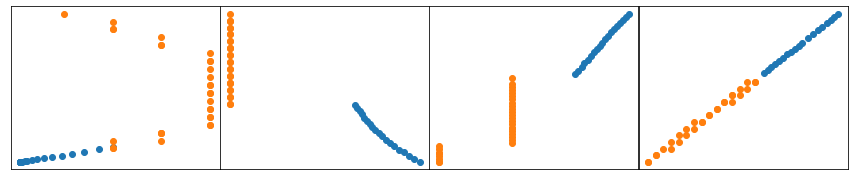

In [45]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break

In [234]:
out

tensor([[[[ 2.9620e+03,  1.4230e+03,  2.0000e+00,  2.0000e+00],
          [ 2.9620e+03,  1.4230e+03,  2.0000e+00,  3.0000e+00],
          [ 2.9620e+03,  1.4240e+03,  2.0000e+00,  3.0000e+00],
          ...,
          [ 2.9620e+03,  1.4380e+03, -3.0000e+00,  6.0000e+00],
          [ 2.9620e+03,  1.4390e+03, -4.0000e+00,  7.0000e+00],
          [ 2.9610e+03,  1.4400e+03, -4.0000e+00,  6.0000e+00]],

         [[ 2.9610e+03,  1.4480e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9610e+03,  1.4480e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9610e+03,  1.4470e+03,  0.0000e+00,  0.0000e+00],
          ...,
          [ 2.9610e+03,  1.4470e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9610e+03,  1.4470e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9610e+03,  1.4480e+03,  0.0000e+00,  0.0000e+00]],

         [[ 2.9770e+03,  1.4440e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9770e+03,  1.4440e+03,  0.0000e+00,  0.0000e+00],
          [ 2.9770e+03,  1.4440e+03,  0.0000e+00,  0.0000e+00],
      

In [47]:
class NN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(NN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
#         out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [48]:
from tqdm import tqdm_notebook as tqdm
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(iterator):
        data, target = torch.reshape(data, (4, 60, -1)).to(device), torch.reshape(target[:,:,:,:2], (4, 60, -1)).to(device)
        optimizer.zero_grad()
        output = model(data)
#         break
        loss = nn.MSELoss()(output, target)
#         print(loss)
        loss.backward()
        optimizer.step()
        counter += 1
        iterator.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))

In [213]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, agent in test_loader:
            data, agent = torch.reshape(data, (4, 60, -1)).to(device)
            output = model(data)
#             print(output)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [64]:
# input dimension
input_dim = 76
hidden_dim = 60  # hidden layer dimension
layer_dim = 1   # number of hidden layers
output_dim = 60   # output dimension

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
    
learning_rate = 0.0001
momentum = 0.5

In [65]:
# net = NN(input_dim, output_dim, hidden_dim, layer_dim)
# model = net.to(device) #using cpu here
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                       momentum=momentum, weight_decay=1e-5)
# num_epoch = 10

# for epoch in range(1, num_epoch + 1):
#         train(model, device, train_loader, optimizer, epoch)
#         torch.save(model.state_dict(), 'checkpoints/train-epoch{}.pth'.format(epoch + 1)) 

In [66]:
model=torch.load("checkpoints/train-epoch3.pth",map_location='cpu')

In [67]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [224]:
batch_sz = 4

def my_test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
#     print(batch)
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.tensor(inp, dtype=torch.float)
    agent = [scene['agent_id'] for scene in batch]
    track = [scene['track_id'] for scene in batch]
    track_ids = []
    for scene in range(len(agent)):
        for track_id in range(len(track[scene])):
            if agent[scene] == track[scene][track_id][0][0]:
                track_ids.append(track_id)
                break
    return [inp, track_ids]

# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=val_path)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_test_collate, num_workers=0, drop_last=True)


In [231]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for data, agent in test_loader:
            data = torch.reshape(data, (4, 60, -1)).to(device)
            output = torch.reshape(model(data), (4, 60, 30, -1))
            for i in range(len(agent)):
                scene = output[i][agent[i]]
                predictions.append(scene)
    return predictions
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [232]:
net = NN(input_dim, output_dim, hidden_dim, layer_dim)
net.load_state_dict(torch.load("checkpoints/train-epoch3.pth",map_location='cpu'))
model = net.to(device)
preds = test(model, device, val_loader)

In [245]:
predict = [torch.reshape(t, (-1,)) for t in preds]

In [31]:
# with torch.no_grad():
#     net = NN(input_dim, output_dim, hidden_dim, layer_dim)
#     net.load_state_dict(torch.load("checkpoints/train-epoch3.pth",map_location='cpu'))
#     net.eval()
    
#     output = net(data)
    

In [241]:
sample = pd.read_csv('sample_submission.csv')

In [252]:
preds_df = sample.set_index('ID')
for i in range(3200):
    preds_df.iloc[i] = predict[i].tolist()

In [254]:
preds_df.to_csv('test_preds.csv')